In [5]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from joblib import dump
from src.get_country_data_grouped import get_country_data_grouped

In [6]:
# Manually add dummy variables to allow us to train a model on a per country basis 
# while still including all information of the other countries
grouped_transpose = get_country_data_grouped().copy()

country_codes = list(set(grouped_transpose.columns.get_level_values(0)))

df = None

for code in country_codes:
    country_data = grouped_transpose[code]
    country_data['country_code'] = code
    country_data = country_data.reset_index(drop=True)
    
    if df is None:
        df = pd.DataFrame(columns=country_data.columns)
    
    df = pd.concat([df, country_data], ignore_index=True)

series_code_total_fertility_rate = 'SP.DYN.TFRT.IN'

df = df[df[series_code_total_fertility_rate].notna()]

df.head()

/var/folders/s7/5vbrzq7x741_dp271_qgj7wc0000gn/T/ipykernel_71897/3998529002.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['country_code'] = code
/var/folders/s7/5vbrzq7x741_dp271_qgj7wc0000gn/T/ipykernel_71897/3998529002.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['country_code'] = code
/var/folders/s7/5vbrzq7x741_dp271_qgj7wc0000gn/T/ipykernel_71897/3998529002.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Series Code,AG.LND.FRST.K2,AG.SRF.TOTL.K2,BX.KLT.DINV.CD.WD,BX.TRF.PWKR.CD.DT,DT.DOD.DECT.CD,DT.ODA.ALLD.CD,DT.TDS.DECT.EX.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.PC,...,SP.DYN.CONU.ZS,SP.DYN.LE00.IN,SP.DYN.TFRT.IN,SP.POP.GROW,SP.POP.TOTL,SP.URB.GROW,TG.VAL.TOTL.GD.ZS,TT.PRI.MRCH.XD.WD,TX.VAL.TECH.MF.ZS,country_code
0,NaN,3287260,37909999.9,NaN,10965917520.3,778710021.972656,NaN,100.406389295402,268.000140169353,NaN,...,NaN,49.539,5.402,2.25117630687251,596107483,3.87175166729346,7.16597167933881,NaN,NaN,IND
1,NaN,3287260,56969999.9,NaN,12696953185.8,1230400024.41406,NaN,103.835854845252,272.302346549436,NaN,...,NaN,50.244,5.325,2.25820438079867,609721951,3.8815236778261,9.10516768045782,NaN,NaN,IND
2,NaN,3287260,-10326246.7051639,429883697.5,13865614018.8,1605189941.40625,15.2717461739867,114.48151944199,275.721350929594,NaN,...,NaN,50.812,5.195,2.23845727724451,623524219,3.84990860184592,10.9025034184956,NaN,NaN,IND
3,NaN,3287260,-7706430.54257424,642343811,14586390285.7,1744609985.35156,18.1022335305653,124.158475517339,280.526500584559,NaN,...,NaN,51.388,5.13,2.20905061418648,637451448,3.81340042301804,10.9173574428921,NaN,NaN,IND
4,NaN,3287260,-36060000,934415893.6,15414657569.6,988809997.558594,15.6147263717526,126.396833781334,282.260531914017,NaN,...,NaN,51.909,5.007,2.20841658709872,651685628,3.80559488235445,10.7213430204091,NaN,NaN,IND


In [7]:
# Save the output to JSON for repeat use
df.to_json(Path('processed.json'))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12589 entries, 0 to 13298
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AG.LND.FRST.K2     7695 non-null   object
 1   AG.SRF.TOTL.K2     12111 non-null  object
 2   BX.KLT.DINV.CD.WD  10874 non-null  object
 3   BX.TRF.PWKR.CD.DT  9073 non-null   object
 4   DT.DOD.DECT.CD     5820 non-null   object
 5   DT.ODA.ALLD.CD     9554 non-null   object
 6   DT.TDS.DECT.EX.ZS  4912 non-null   object
 7   EG.USE.ELEC.KH.PC  7141 non-null   object
 8   EG.USE.PCAP.KG.OE  7331 non-null   object
 9   EN.ATM.CO2E.PC     7342 non-null   object
 10  EN.CLC.MDAT.ZS     167 non-null    object
 11  EN.POP.DNST        12111 non-null  object
 12  ER.H2O.FWTL.ZS     6132 non-null   object
 13  ER.PTD.TOTL.ZS     1471 non-null   object
 14  FS.AST.DOMS.GD.ZS  1287 non-null   object
 15  GC.REV.XGRT.GD.ZS  4955 non-null   object
 16  GC.TAX.TOTL.GD.ZS  5003 non-null   object
 17

In [9]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Encode (convert to dummy variables) the country_code column
scaled_data = enc.fit_transform(df[['country_code']])

df_country_code = pd.DataFrame(data=scaled_data, columns=enc.get_feature_names_out(['country_code']))

dump(enc, 'onehotencoder.joblib')

df_country_code

/Users/davidrosenbloom/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,country_code_ABW,country_code_AFE,country_code_AFG,country_code_AFW,country_code_AGO,country_code_ALB,country_code_AND,country_code_ARB,country_code_ARE,country_code_ARG,...,country_code_VIR,country_code_VNM,country_code_VUT,country_code_WLD,country_code_WSM,country_code_XKX,country_code_YEM,country_code_ZAF,country_code_ZMB,country_code_ZWE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_scaled = df.drop(columns='country_code')

scaler = StandardScaler().fit(df_scaled)

dump(enc, 'scaler.joblib')

scaled_data = scaler.transform(df_scaled)

df_scaled = pd.DataFrame(data=scaled_data, columns=df_scaled.columns)

df_scaled

Series Code,AG.LND.FRST.K2,AG.SRF.TOTL.K2,BX.KLT.DINV.CD.WD,BX.TRF.PWKR.CD.DT,DT.DOD.DECT.CD,DT.ODA.ALLD.CD,DT.TDS.DECT.EX.ZS,EG.USE.ELEC.KH.PC,EG.USE.PCAP.KG.OE,EN.ATM.CO2E.PC,...,SP.ADO.TFRT,SP.DYN.CONU.ZS,SP.DYN.LE00.IN,SP.DYN.TFRT.IN,SP.POP.GROW,SP.POP.TOTL,SP.URB.GROW,TG.VAL.TOTL.GD.ZS,TT.PRI.MRCH.XD.WD,TX.VAL.TECH.MF.ZS
0,NaN,-0.145483,-0.205386,NaN,-0.184016,-0.247359,NaN,-0.673970,-0.686936,NaN,...,1.830165,NaN,-1.653183,0.994850,0.376488,0.458224,0.443352,-1.136858,NaN,NaN
1,NaN,-0.145483,-0.205267,NaN,-0.180985,-0.213661,NaN,-0.673156,-0.685370,NaN,...,1.788088,NaN,-1.583750,0.953182,0.380831,0.475887,0.446787,-1.093456,NaN,NaN
2,NaN,-0.145483,-0.205686,-0.258638,-0.178939,-0.185700,-0.098020,-0.670630,-0.684126,NaN,...,1.712409,NaN,-1.527809,0.882835,0.368627,0.493792,0.435676,-1.053230,NaN,NaN
3,NaN,-0.145483,-0.205670,-0.254048,-0.177677,-0.175298,0.097686,-0.668333,-0.682378,NaN,...,1.661052,NaN,-1.471081,0.847661,0.350452,0.511860,0.422846,-1.052897,NaN,NaN
4,NaN,-0.145483,-0.205846,-0.247738,-0.176226,-0.231684,-0.074306,-0.667802,-0.681747,NaN,...,1.418112,NaN,-1.419769,0.781101,0.350060,0.530326,0.420102,-1.057284,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12584,-0.244746,-0.296059,-0.206045,-0.267926,NaN,-0.298975,NaN,NaN,NaN,0.089437,...,0.401290,NaN,0.553320,-0.687002,-1.373796,-0.275458,-1.114273,NaN,2.156404,NaN
12585,-0.244926,-0.296059,-0.200109,-0.267926,NaN,-0.294332,NaN,NaN,NaN,0.048597,...,0.356188,NaN,0.556865,-0.698907,-2.525045,-0.276415,-1.766121,NaN,2.446066,NaN
12586,-0.245058,-0.296059,-0.213574,-0.267926,NaN,-0.286067,NaN,NaN,NaN,-0.078637,...,0.337670,NaN,0.574790,-0.710812,-2.810242,-0.277523,-1.925508,NaN,1.713931,NaN
12587,-0.245140,-0.296059,-0.208459,-0.267926,NaN,-0.280708,NaN,NaN,NaN,-0.305616,...,0.311579,NaN,0.469803,-0.721635,-2.050044,-0.278147,-1.490453,NaN,0.703698,NaN


In [11]:
df_final = pd.concat([df_scaled, df_country_code], axis=1)

df_final = df_final.fillna(0).sample(frac=1).reset_index(drop=True)

In [12]:
y = df_final[series_code_total_fertility_rate]
X = df_final.copy().drop(columns=series_code_total_fertility_rate)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

316

In [14]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [15]:
# Define the number of hidden nodes for each layer
hidden_nodes_layer1 =  (number_input_features + number_output_neurons) // 2
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons) // 2
hidden_nodes_layer3 =  (hidden_nodes_layer2 + number_output_neurons) // 2
hidden_nodes_layer4 =  (hidden_nodes_layer3 + number_output_neurons) // 2
hidden_nodes_layer5 =  (hidden_nodes_layer4 + number_output_neurons) // 2
hidden_nodes_layer6 =  (hidden_nodes_layer5 + number_output_neurons) // 2

In [16]:
# Create the Sequential model instance
nn = Sequential()

# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add the third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))

# Add the fourth hidden layer
nn.add(Dense(units=hidden_nodes_layer4, activation="relu"))

# Add the fifth hidden layer
nn.add(Dense(units=hidden_nodes_layer5, activation="relu"))

# Add the sixth hidden layer
nn.add(Dense(units=hidden_nodes_layer6, activation="relu"))

# Add the output layer we want to have an unlimited negative or positive number so we use the linear activation
nn.add(Dense(units=number_output_neurons, activation="linear"))

# Display the Sequential model summary
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 158)               50086     
                                                                 
 dense_1 (Dense)             (None, 79)                12561     
                                                                 
 dense_2 (Dense)             (None, 40)                3200      
                                                                 
 dense_3 (Dense)             (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
 dense_6 (Dense)             (None, 1)                 6

In [17]:
# Compile the Sequential model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [18]:
fit_model = nn.fit(X_train, y_train, epochs=25)

Epoch 1/25
296/296 [==============================] - 0s 729us/step - loss: 0.1237 - mse: 0.1237
Epoch 2/25
296/296 [==============================] - 0s 788us/step - loss: 0.0266 - mse: 0.0266
Epoch 3/25
296/296 [==============================] - 0s 732us/step - loss: 0.0135 - mse: 0.0135
Epoch 4/25
296/296 [==============================] - 0s 770us/step - loss: 0.0099 - mse: 0.0099
Epoch 5/25
296/296 [==============================] - 0s 789us/step - loss: 0.0078 - mse: 0.0078
Epoch 6/25
296/296 [==============================] - 0s 753us/step - loss: 0.0067 - mse: 0.0067
Epoch 7/25
296/296 [==============================] - 0s 753us/step - loss: 0.0077 - mse: 0.0077
Epoch 8/25
296/296 [==============================] - 0s 765us/step - loss: 0.0086 - mse: 0.0086
Epoch 9/25
296/296 [==============================] - 0s 901us/step - loss: 0.0064 - mse: 0.0064
Epoch 10/25
296/296 [==============================] - 0s 784us/step - loss: 0.0047 - mse: 0.0047
Epoch 11/25
296/296 [========

In [19]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

99/99 - 0s - loss: 0.0083 - mse: 0.0083 - 124ms/epoch - 1ms/step
Loss: 0.00825964380055666, Accuracy: 0.00825964380055666


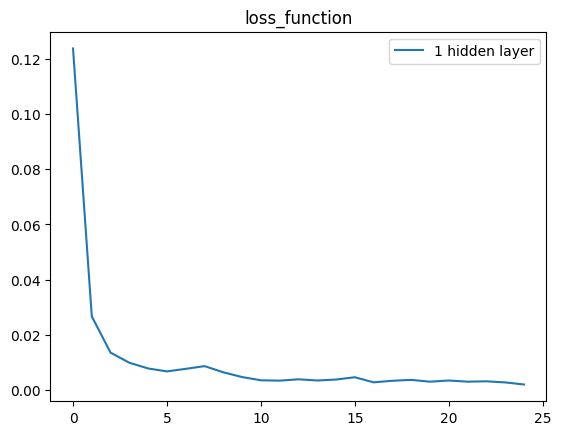

In [20]:
plt.plot(fit_model.history["loss"])
plt.title("loss_function")
plt.legend(["1 hidden layer"])
plt.show()

In [21]:
file_path = 'WorldBankFertilityModel.h5'

# Export the model to a HDF5 file
nn.save(file_path)

/Users/davidrosenbloom/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
